# Loading modules

In [7]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

# Training model

In [8]:
BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/20_newsgroup/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128

# Training word embeddings
## Download text8 corpus

In [15]:
import os
import zipfile
from keras.utils import get_file


def maybe_download(url):
    """
    Download a file if not present.
    """
    filename = url.split('/')[-1]
    path = get_file(filename, url)
    return path
    

def unzip(zip_filename):
    """
    Extract a file from the zipfile
    """
    with zipfile.ZipFile(zip_filename) as f:
        for filename in f.namelist():
            dirname = os.path.dirname(filename)
            f.extract(filename, dirname)
            return os.path.abspath(filename)
            

url = 'http://mattmahoney.net/dc/text8.zip'
filename = maybe_download(url)
text_file = unzip(filename)

## Training word2vec

In [16]:
from gensim.models import word2vec

sentences = word2vec.Text8Corpus(text_file)
window_sizes = [1, 2, 4, 8, 16]
model_names = {}
for window_size in window_sizes:
    out_model = "text8.ws{}.txt".format(window_size)
    model_names[window_size] = out_model
    if os.path.exists(out_model):
        continue
    print('Starting training with window size {}...'.format(window_size))
    model = word2vec.Word2Vec(sentences, size=200, sg=1, window=window_size, workers=multiprocessing.cpu_count())
    model.wv.save_word2vec_format(out_model)
    # model.save(out_model)
    print('Finished')
print(model_names)

{8: 'text8.ws8.txt', 1: 'text8.ws1.txt', 2: 'text8.ws2.txt', 4: 'text8.ws4.txt', 16: 'text8.ws16.txt'}


# Preprocessing text dataset

In [9]:
from sklearn.datasets import fetch_20newsgroups

print('Load text dataset')
newsgroups = fetch_20newsgroups(subset='all')

texts = []  # list of text samples                                                                                                                                     
labels = []  # list of label ids                                                                                                                                       
label_num = len(newsgroups.target_names)  # number of labels                                                                                                           
for text, label_id in zip(newsgroups.data, newsgroups.target):
    idx = text.find('\n\n')  # skip header                                                                                                                             
    text = text[idx:]
    text = text.strip()      # remove new line                                                                                                                         
    texts.append(text)
    labels.append(label_id)

print('Found %s texts.' % len(texts))

print('Processing text dataset')
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

Load text dataset


Found 18846 texts.
Processing text dataset


Found 172780 unique tokens.


Shape of data tensor: (18846, 1000)
Shape of label tensor: (18846, 20)


# Preparing embedding matrix

## Indexing word vectors

In [10]:
def index_word_vectors(file_path):
    print('Indexing word vectors.')
    
    embeddings_index = {}
    with open(file_path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [11]:
def prepare_embedding_matrix(embeddings_index):
    print('Preparing embedding matrix.')
    
    # prepare embedding matrix
    num_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix, num_words

# Building model

In [12]:
def build_model(embedding_matrix, num_words):
    print('Build model.')
    # build a 1D convnet with global maxpooling
    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(35)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(label_num, activation='softmax')(x)
    
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

# Training model

In [14]:
accuracies = []
for window_size in window_sizes:
    path = 'text8.ws{}.txt'.format(window_size)
    embeddings_index = index_word_vectors(file_path=path)
    embedding_matrix, num_words = prepare_embedding_matrix(embeddings_index)
    model = build_model(embedding_matrix, num_words)
    
    print('Training model: window size {}'.format(window_size))
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=BATCH_SIZE, verbose=2)
    score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=2)
    accuracies.append(acc)

Indexing word vectors.


Found 71291 word vectors.
Preparing embedding matrix.
Build model.


Training model: window size 1


Train on 15077 samples, validate on 3769 samples
Epoch 1/3


313s - loss: 2.6724 - acc: 0.1090 - val_loss: 2.3311 - val_acc: 0.1467
Epoch 2/3


288s - loss: 2.1965 - acc: 0.2213 - val_loss: 2.0105 - val_acc: 0.3003
Epoch 3/3


289s - loss: 1.8145 - acc: 0.3431 - val_loss: 1.7069 - val_acc: 0.3929


Indexing word vectors.


Found 71291 word vectors.
Preparing embedding matrix.
Build model.


Training model: window size 2


Train on 15077 samples, validate on 3769 samples
Epoch 1/3


291s - loss: 2.8147 - acc: 0.0990 - val_loss: 2.4547 - val_acc: 0.1555
Epoch 2/3


308s - loss: 2.0630 - acc: 0.2669 - val_loss: 1.7964 - val_acc: 0.3569
Epoch 3/3


294s - loss: 1.6548 - acc: 0.3912 - val_loss: 1.6165 - val_acc: 0.4120


Indexing word vectors.


Found 71291 word vectors.
Preparing embedding matrix.
Build model.


Training model: window size 4


Train on 15077 samples, validate on 3769 samples
Epoch 1/3


345s - loss: 2.6002 - acc: 0.1222 - val_loss: 2.3344 - val_acc: 0.1592
Epoch 2/3


322s - loss: 2.0829 - acc: 0.2464 - val_loss: 1.8001 - val_acc: 0.3401
Epoch 3/3


298s - loss: 1.6512 - acc: 0.3930 - val_loss: 1.5705 - val_acc: 0.4160


Indexing word vectors.


Found 71291 word vectors.
Preparing embedding matrix.
Build model.


Training model: window size 8


Train on 15077 samples, validate on 3769 samples
Epoch 1/3


299s - loss: 2.6848 - acc: 0.0990 - val_loss: 2.3404 - val_acc: 0.1722
Epoch 2/3


289s - loss: 2.0618 - acc: 0.2570 - val_loss: 1.7600 - val_acc: 0.3447
Epoch 3/3


308s - loss: 1.6049 - acc: 0.3994 - val_loss: 1.5201 - val_acc: 0.4346


Indexing word vectors.


Found 71291 word vectors.
Preparing embedding matrix.
Build model.


Training model: window size 16


Train on 15077 samples, validate on 3769 samples
Epoch 1/3


297s - loss: 2.6362 - acc: 0.1144 - val_loss: 2.2946 - val_acc: 0.1772
Epoch 2/3


331s - loss: 2.1497 - acc: 0.2223 - val_loss: 1.9222 - val_acc: 0.3011
Epoch 3/3


288s - loss: 1.6165 - acc: 0.4110 - val_loss: 1.4168 - val_acc: 0.5076


# Evaluation

## Word similarity
### Calculating Spearman's correlation by wordsim353

In [17]:
import gensim.test
from gensim.models import KeyedVectors
module_path = gensim.test.__path__[0]
spearmans = []
for window_size in window_sizes:
    model_name = model_names[window_size]
    word_vectors = KeyedVectors.load_word2vec_format(model_name)
    _, spearman, _ = word_vectors.evaluate_word_pairs(os.path.join(module_path, 'test_data', 'wordsim353.tsv'))
    spearmans.append(spearman.correlation)
    print(spearman.correlation)

0.546604463077


0.62974217854


0.673909870363


0.711368463157


0.716476219727


### Plotting Spearman's correlation

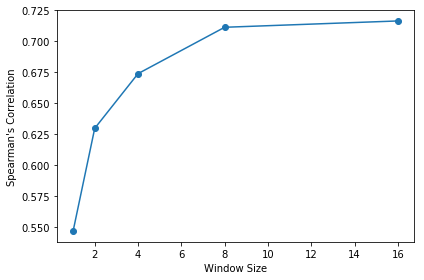

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(window_sizes, spearmans, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Spearman\'s Correlation')

plt.tight_layout()
plt.show()

## Plotting classification accuracy

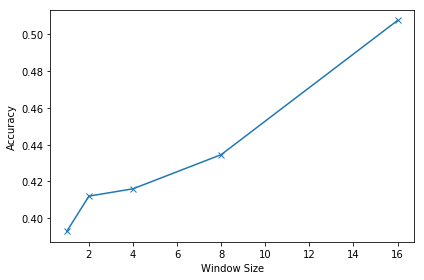

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(window_sizes, accuracies, marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()